In [1]:
code_dir = "../UXO_protected/+BTInvertPY"

In [189]:
import sys
sys.path.append(code_dir)

from BTSensor import (
    SensorInfo, Model, preCalcLoopCorners, FModParam, 
    forwardWithQ, sensorCoords2RxCoords, hprimary, formQmatrix,
)
import numpy as np
import os
import h5py
import pandas as pd
from scipy import stats

import matplotlib.pyplot as plt
from matplotlib import cm as cmap
from matplotlib import colors
from matplotlib.colors import Normalize
from mpl_toolkits import mplot3d

In [3]:
from matplotlib import rcParams
rcParams['font.size'] = 14
np.random.seed(2020)

In [4]:
afile = os.path.join(code_dir,'config','sensor_definitions','UltraTEMArrayNA___Default.yaml')
sensorinfo = SensorInfo.fromYAML(afile)[0]

## set up survey parameters
- x is cross-line
- y is inline

In [5]:
ntx = len(sensorinfo.transmitters)
ymax = 5
dy = 0.2 / ntx
nloc = int(ymax/dy)
ncycles = int(nloc/ntx)

y = np.linspace(0, ymax-dy, nloc)
x = np.zeros(nloc)
z = 0.28 * np.ones(nloc)

pitch = np.zeros(nloc)
roll = np.zeros(nloc)
yaw = np.zeros(nloc)  # moving north (sensor in typical orientation)

txnum = np.kron(np.ones(ncycles), np.arange(ntx))

In [99]:
len(txnum)

125

In [7]:
# Convert sensor location coordinates to Rx locations
pos, mnum = sensorCoords2RxCoords(
    sensorinfo=sensorinfo,
    x = x, 
    y = y, 
    z = z, 
    pitch = pitch, 
    roll = roll, 
    yaw = yaw,
    txnum = txnum
)

pitch = np.concatenate([np.tile(x,pos[i].shape[0]) for i,x in enumerate(pitch)])
roll = np.concatenate([np.tile(x,pos[i].shape[0]) for i,x in enumerate(roll)])
yaw = np.concatenate([np.tile(x,pos[i].shape[0]) for i,x in enumerate(yaw)])
pos = np.concatenate(pos,axis=0)

In [8]:
for i in range(3):
    print(pos[:, i].min(), pos[:, i].max())

-1.0 1.0
-0.25 5.21
0.28 0.28


# ordnance objects

In [9]:
filename = "ordnance_DoD_UltraTEM_5F_APG.h5"
ord_file = os.path.join(code_dir, filename)
f = h5py.File(ord_file, 'r')

In [10]:
f["ordnance"]["1"]

<HDF5 group "/ordnance/1" (27 members)>

In [11]:
# Load the ordnance objects

def load_ord(filename="ordnance_DoD_UltraTEM_5F_ISOsmall.h5", ordi=1):
    ord_file = os.path.join(code_dir, filename)
    f = h5py.File(ord_file, 'r')
    ord_name = str(f['ordnance/{}/Name'.format(ordi)][()][0]).split("'")[1]
    ord_dict = {
        "L3": f[f'ordnance/{ordi}/L1ref'][()].flatten(),
        "L2": f[f'ordnance/{ordi}/L2ref'][()].flatten(),
        "L1": f[f'ordnance/{ordi}/L3ref'][()].flatten(),
        "times": f[f'ordnance/{ordi}/time'][()].flatten()
    }
    f.close()
    return ord_name, ord_dict

In [12]:
ordnance = {}
for f in ["ordnance_DoD_UltraTEM_5F_ISOsmall.h5", "ordnance_DoD_UltraTEM_5F_APG.h5"]:
    name, data = load_ord(f)
    ordnance[name] = data
times = ordnance["ISO Small"]["times"]

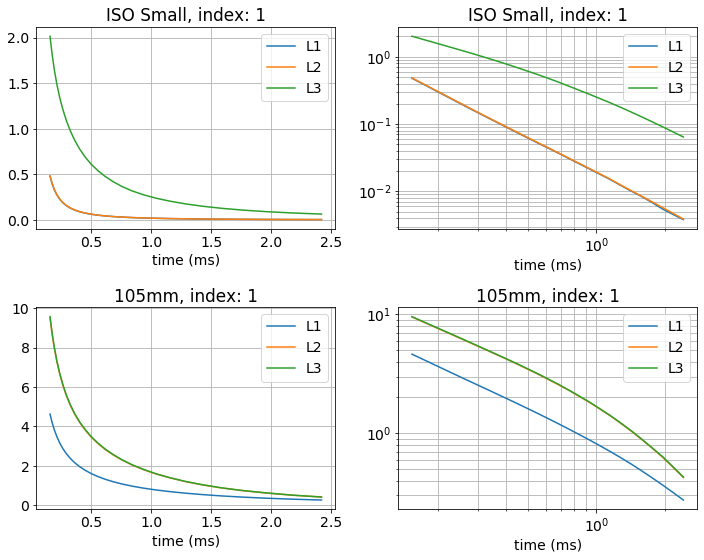

In [13]:
fig, ax = plt.subplots(len(ordnance.keys()), 2, figsize=(10, 4*len(ordnance.keys())))

for i, key in enumerate(ordnance.keys()):
    for l in ["L1", "L2", "L3"]:
        L = ordnance[key][l]
        ax[i, 0].plot(times, L, label=l)
        ax[i, 1].loglog(times, L, label=l)

    for a in ax[i, :]:
        a.set_title(f"{key}, index: {1}")
        a.grid(which="both")
        a.legend()
        a.set_xlabel("time (ms)")
plt.tight_layout()

# ranges of parameters

In [14]:
depth_range_iso_small = np.r_[0.2, 0.7]
depth_range_105mm = np.r_[0.1, 0.5]

x_range = np.r_[-1.25, 1.25]
y_range = np.r_[0., ymax]

yaw_range = np.r_[0, 2*np.pi]
pitch_range = np.r_[0, 2*np.pi]
roll_range = np.r_[0, 2*np.pi]

def generate_random_variables(n, bounds):
    return bounds.min() + (bounds.max() - bounds.min()) * np.random.rand(n)

In [15]:
ntrain = 2048
ntest = 1024
nvalid = 1024

class_dict = {
    0: "not TOI",
    1: "ISO Small",
    2: "105mm"
}
n_class = len(class_dict.keys())

In [16]:
labels_train = np.random.choice(n_class, ntrain)
labels_test = np.random.choice(n_class, ntest)
labels_valid = np.random.choice(n_class, nvalid)

def generate_parameters(labels):
    n = len(labels)
    i0 = labels == 0
    i1 = labels == 1
    i2 = labels == 2
    
    depths = np.zeros(n)
    depths[i1] = generate_random_variables(i1.sum(), depth_range_iso_small)
    depths[i2] = generate_random_variables(i2.sum(), depth_range_105mm)
    
    x = generate_random_variables(n, x_range)
    y = generate_random_variables(n, y_range)
    z = -depths
    
    yaw = generate_random_variables(n, yaw_range)
    pitch = generate_random_variables(n, pitch_range)
    roll = generate_random_variables(n, roll_range)
    
    return pd.DataFrame({
        "label": labels,
        "depth": depths,
        "x": x,
        "y": y,
        "z": z,
        "yaw": yaw,
        "pitch": pitch,
        "roll": roll
    })

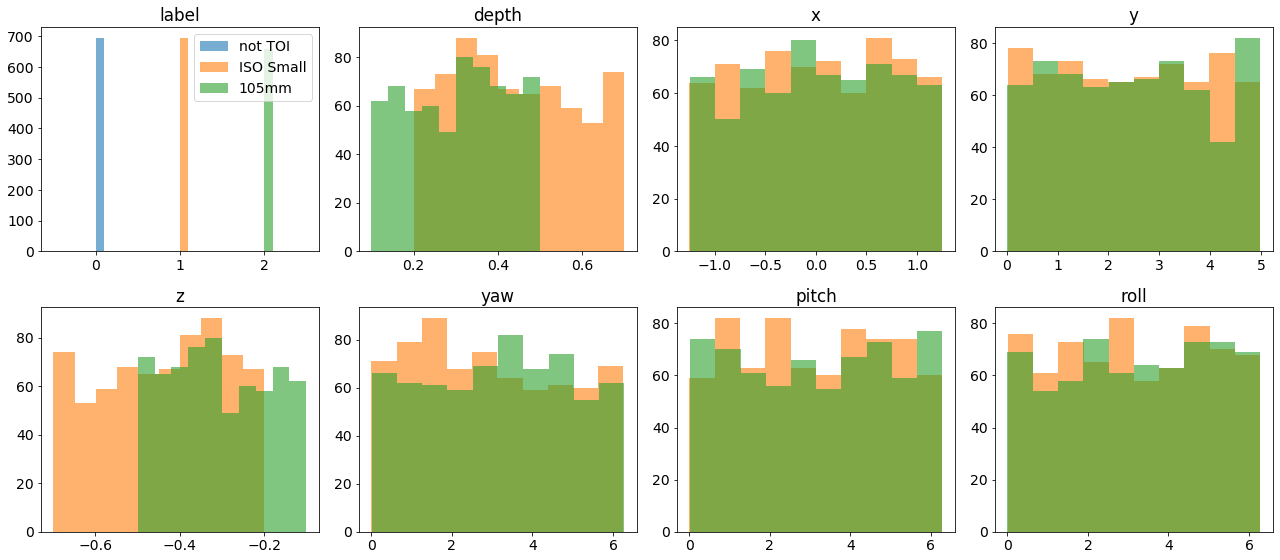

In [17]:
params_train = generate_parameters(labels_train) 
params_test = generate_parameters(labels_test) 
params_valid = generate_parameters(labels_valid) 

fig, ax = plt.subplots(2, 4, figsize=(18, 8))
ax = ax.flatten()

i = 0
for key, val in params_train.items():
    for j in range(3):
        if key != "label" and j ==0: 
            pass  # these parameters are irrelevant if there is no object
        else:
            inds = labels_train == j
            ax[i].hist(val[inds], 10, color=f"C{j}", alpha=0.6)
    ax[i].set_title(key)
    i += 1

ax[0].legend([class_dict[0], class_dict[1], class_dict[2]])
plt.tight_layout()

# set up forward simulations

In [18]:
# figuring out where all of the vertices are in coordinate system -- gives us location of vertices 
Tx_indices_rot, Rx_indices_rot = preCalcLoopCorners(
    sensorinfo=sensorinfo, mnum=mnum, rlist=pos, pitch=pitch, roll=roll, yaw=yaw
) 

# convienence object for inputs to fwd modelling 
st = FModParam(sensorinfo, pos, mnum, times, Tx_indices_rot, Rx_indices_rot)  

In [19]:
def run_simulations(parameters):
    data = []
    for i, l in enumerate(parameters["label"]):
        if l == 0:
            # this can later be replaced with random noise or other structured but uninteresting signal
            V = np.zeros((pos.shape[0], len(times)))
        else: 
            xyz = np.r_[parameters["x"][i], parameters["y"][i], parameters["z"][i]]
            ypr = np.r_[parameters["yaw"][i], parameters["pitch"][i], parameters["roll"][i]]
            L3 = ordnance[class_dict[l]]["L3"]
            L2 = ordnance[class_dict[l]]["L2"]
            L1 = ordnance[class_dict[l]]["L1"]
            
            mod = Model(xyz=xyz, gba=ypr, l3=L3, l2=L2, l1=L1, times=times)
            V = forwardWithQ(mod, st) # nT/s (some version of db/dt)
        V = V.reshape(ncycles, mnum.max()+1, len(times))
        V = np.swapaxes(V, 0, 1)
        data.append(V)
    return data
    
    

In [20]:
%%time
data_train = run_simulations(params_train)

CPU times: user 12.3 s, sys: 2.04 s, total: 14.3 s
Wall time: 2.48 s


In [21]:
%%time
data_test = run_simulations(params_test)
data_valid = run_simulations(params_valid)

CPU times: user 12.5 s, sys: 2.15 s, total: 14.7 s
Wall time: 2.53 s


## plot some sample data

In [22]:
pos = np.swapaxes(pos.reshape(ncycles, mnum.max()+1, 3), 0, 1)

In [23]:
dind = 3
d = data_train[dind]

print(f"class: {class_dict[labels_train[dind]]}, data shape: {d.shape}")

params_train.iloc[dind]

class: ISO Small, data shape: (165, 25, 27)


label    1.000000
depth    0.597848
x       -0.577764
y        0.277632
z       -0.597848
yaw      0.811896
pitch    5.696828
roll     4.502659
Name: 3, dtype: float64

In [24]:
# tx_num, rx_num, rx_comp, rxcube
sensor_table = sensorinfo.measNum2TxRxRxcCube()

In [25]:
len(sensor_table)

165

Text(0.5, 0.92, 'Transmitter 5, Target 3: ISO Small')

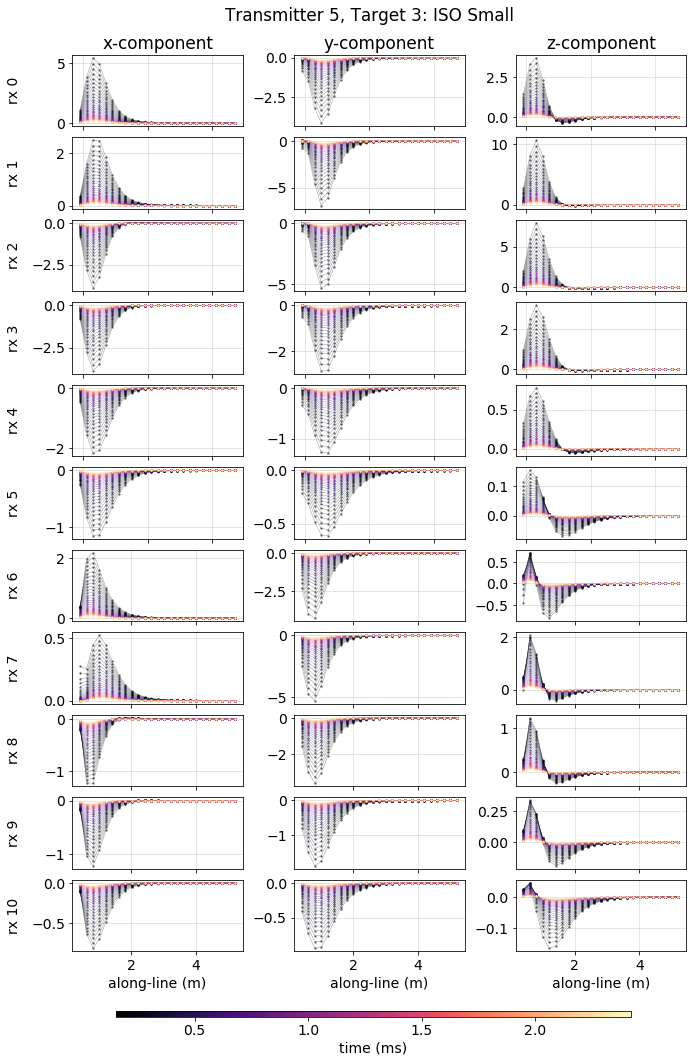

In [26]:
nrx = 11
fig, ax = plt.subplots(nrx, 3, figsize=(11, 1.5*nrx))
fig.subplots_adjust(wspace=0.3, hspace=0.15)

plot_tx = 4
tx_inds = (sensor_table[:, 0] == plot_tx)

cm = plt.get_cmap('magma')
c_norm = Normalize(vmin=times.min(), vmax=times.max())
scalar_map = cmap.ScalarMappable(norm=c_norm, cmap=cm)
scalar_map.set_array([])

for rx in range(nrx):
    ii = tx_inds & (sensor_table[:, 3] == rx)
    for a, comp in zip(ax[rx, :], [0, 1, 2]):
        mnumind = np.where( ii & (sensor_table[:, 2] == comp))[0][0]
        for t in range(len(times)):
            a.plot(
                pos[mnumind, :, 1], d[mnumind, :, t], 
                color=scalar_map.to_rgba(times[t]), marker=".", lw=0.5, alpha=0.4, ms=3
            )

        a.grid(which="both", alpha=0.4)
        if rx < nrx-1:
            a.set_xticklabels('')
        else:
            a.set_xlabel("along-line (m)")
        
        if rx == 0:
            if comp == 0:
                a.set_title("x-component")
            elif comp == 1:
                a.set_title("y-component")
            elif comp == 2:
                a.set_title("z-component")
        
        if comp == 0:
            a.set_ylabel(f"rx {rx}")
            a.yaxis.set_label_coords(-0.3, 0.5)
            
# plt.tight_layout()
cbar_ax = fig.add_axes([0.18, 0.07, 0.65, 0.005])
cb = plt.colorbar(scalar_map, cbar_ax, orientation="horizontal")
cb.set_label('time (ms)')

fig.suptitle(f"Transmitter {plot_tx+1}, Target {dind}: {class_dict[labels_train[dind]]}", y=0.92)


# build a CNN classifier 

In [27]:
import torch
from torch import nn
from torch.nn import functional

In [28]:
class ConvNet(nn.Module):
    
    def __init__(self, network_geometry, h=1, npool=3):
        super().__init__()
        self.h = h
        self.network_geometry=network_geometry
        self.nt = len(network_geometry)
#         self.npool = npool
    
    def forward(self, X, K, batch_norm):
            
        for i, Ki, bn in zip(range(self.nt), K, batch_norm): 
            z = functional.conv2d(X, Ki, stride=1, padding=1)
            z = bn(z)
            z = functional.relu(z)
            
#             for i in range(self.npool):
#                 z = functional.avg_pool2d(z, 2, stride=1, padding=1)
            
                
#             if self.network_geometry[i] == self.network_geometry[i+1]:
#                 z = functional.conv_transpose2d(z, Ki, stride=1, padding=1)
# #                 X = X - self.h*z
#             else: 
            X = z
        return X

In [57]:
in_channels = 165
n_class = 3
layer_geometries = [in_channels, 4, 4]
nlayers = len(layer_geometries)
initial_scaling = 1

width = nloc//ntx
ntimes = len(times)

batch_size = 32 
net = ConvNet(layer_geometries, h=1)

# initialize K's and batch normalizations
K = []
batch_norm = []
for i in range(nlayers-1):
    n_in = layer_geometries[i]
    n_out = layer_geometries[i+1]
    Ki = nn.Parameter(torch.Tensor(n_out, n_in, 3, 3))
    Ki.data = torch.randn(n_out, n_in, 3, 3)  * initial_scaling
    K.append(Ki)
    
    batch_norm.append(nn.BatchNorm2d(n_out))

# initialize classifier W
W = nn.Parameter(torch.Tensor(layer_geometries[-1]*width*ntimes, n_class))
W.data = torch.randn(layer_geometries[-1]*width*ntimes, n_class)

In [58]:
net = ConvNet(layer_geometries)

In [59]:
X_train = torch.from_numpy(np.float32(np.stack(data_train, axis=0)))
X_test = torch.from_numpy(np.float32(np.stack(data_test, axis=0)))
X_valid = torch.from_numpy(np.float32(np.stack(data_valid, axis=0)))

C_train = torch.from_numpy(np.float32(labels_train)).long()
C_test = torch.from_numpy(np.float32(labels_test)).long()
C_valid = torch.from_numpy(np.float32(labels_valid)).long()

In [60]:
# run the network

with torch.no_grad():
    out = net(X_train, K, batch_norm)

In [61]:
loss_func = nn.CrossEntropyLoss()

def misfit(X, W, C):
    n = W.shape
    X = X.view(-1, n[0])
    S = torch.matmul(X, W)

    probs = functional.softmax(S, dim=1)
    return loss_func(S, C), probs

In [62]:
K0 = K[0]

In [63]:
n_parout = (
    np.sum(np.array([np.prod(Ki.shape) for Ki in K])) + np.prod(W.shape)
)

print('Total number of parameters',n_parout)
print('Total number of data', labels_train.shape[0])

Total number of parameters 14184
Total number of data 2048


In [64]:
loss, probs = misfit(out, W, C_train)
print('Initial loss = ', loss.detach().numpy())    
print(f'Check:log({n_class}) = ', np.log(n_class))

Initial loss =  22.378601
Check:log(3) =  1.0986122886681098


In [66]:
batch_size = 32

In [67]:
import torch.optim as optim
optimizer = optim.SGD(
    [{'params': W}, {'params': K}], 
    lr = 1e0, momentum=0
)


In [68]:
def accuracy(S, labels):
    _, predicted = torch.max(S, dim=1)
    total = np.prod(labels.size())
    correct = (predicted == labels).sum().item()
    return correct/total

In [69]:
all_loss = []
all_test_loss = []

for epoch in range(500):  # loop over the dataset multiple times

    # zero the parameter gradients
    g = 0.0
    loss = 0.0
    ind = 0
    
    while ind < X_train.shape[1]:    
        optimizer.zero_grad()
        # get the inputs
        inputs = X_train[ind:ind+batch_size, :, :, :]
        labels = C_train[ind:ind+batch_size]

        # forward 
        x = net(inputs, K, batch_norm)
        lossi, _ = misfit(x, W, labels)
        if i==0:
            loss = lossi
        else:
            loss += lossi
        lossi.backward()
        optimizer.step()
        ind += batch_size
    
    if np.mod(epoch, 10) == 0: 
        with torch.no_grad():
            xtest = net(X_test, K, batch_norm)
            loss_test, probs_test = misfit(xtest, W, C_test)

            xtrain = net(X_train, K, batch_norm)
            loss_train, probs_train = misfit(xtrain, W, C_train)

            accuracy_train = accuracy(probs_train, C_train)
            accuracy_test = accuracy(probs_test, C_test)

        print(f'{epoch+1:3d}  {loss:2.3f}  {loss_test:2.3f}  {accuracy_train:0.3f}  {accuracy_test:0.3f}')

print('Finished Training')

  1  80.055  1.814  0.543  0.604
 11  1.807  0.987  0.853  0.841
 21  1.457  1.087  0.813  0.793
 31  1.249  1.166  0.837  0.822
 41  1.075  1.205  0.863  0.850
 51  0.929  1.203  0.876  0.861
 61  0.777  1.219  0.893  0.886
 71  0.628  1.142  0.899  0.886
 81  0.514  1.108  0.905  0.891
 91  0.419  1.046  0.908  0.891
101  0.309  1.004  0.909  0.894
111  0.225  1.016  0.923  0.910
121  0.162  1.047  0.935  0.923
131  0.116  1.091  0.941  0.933
141  0.082  1.131  0.946  0.932
151  0.063  1.151  0.948  0.933
161  0.049  1.192  0.948  0.935
171  0.038  1.263  0.950  0.939
181  0.030  1.304  0.953  0.939
191  0.025  1.317  0.953  0.940
201  0.021  1.317  0.953  0.940
211  0.018  1.312  0.954  0.942
221  0.015  1.293  0.955  0.944
231  0.013  1.263  0.956  0.946
241  0.012  1.240  0.956  0.947
251  0.011  1.223  0.957  0.947
261  0.010  1.200  0.958  0.947
271  0.009  1.162  0.959  0.947
281  0.008  1.166  0.959  0.947
291  0.008  1.136  0.959  0.947
301  0.007  1.137  0.959  0.947
311  0.

In [71]:
# training set
x_train_net = net(X_train, K, batch_norm)
_, probs_train = misfit(x_train_net, W, C_train)
_, pred_train = torch.max(probs_train, dim=1)

# test set
x_test_net = net(X_test, K, batch_norm)
_, probs_test = misfit(x_test_net, W, C_test)
_, pred_test = torch.max(probs_test, dim=1)

# validation set
x_valid_net = net(X_valid, K, batch_norm)
_, probs_valid = misfit(x_valid_net, W, C_valid)
_, pred_valid = torch.max(probs_valid, dim=1)

In [72]:
print(f"training accuracy: {accuracy(probs_train, C_train):1.4f}")
print(f"test accuracy    : {accuracy(probs_test, C_test):1.4f}")
print(f"valid accuracy   : {accuracy(probs_valid, C_valid):1.4f}")

training accuracy: 0.9644
test accuracy    : 0.9502
valid accuracy   : 0.9570


In [73]:
# see where it struggled

def get_mislabeled(S, labels):
    _, predicted = torch.max(S, dim=1)
    incorrect = (predicted != labels)
    return incorrect.numpy()

In [74]:
mislabeled_train = get_mislabeled(probs_train, C_train)
mislabeled_test = get_mislabeled(probs_test, C_test)
mislabeled_valid = get_mislabeled(probs_valid, C_valid)

print(f"Mislabeled. train: {mislabeled_train.sum()}, test: {mislabeled_test.sum()}, valid: {mislabeled_valid.sum()}")

Mislabeled. train: 73, test: 51, valid: 44


In [75]:
params_train.loc[mislabeled_train]

,label,depth,x,y,z,yaw,pitch,roll
70,2,0.427783,0.181415,2.673859,-0.427783,3.717779,5.511961,2.943928
84,2,0.471157,0.766710,4.879510,-0.471157,3.224803,4.222782,3.488857
242,1,0.221786,-1.098030,1.271464,-0.221786,5.916706,5.090156,1.895418
258,2,0.447441,0.351078,2.868705,-0.447441,2.757095,4.921795,5.121478
267,2,0.411534,0.284230,0.264789,-0.411534,1.734242,1.286723,4.997147
...,...,...,...,...,...,...,...,...
1886,2,0.421686,0.343031,4.929883,-0.421686,4.034494,1.992290,0.148761
1915,2,0.473160,0.024985,4.086641,-0.473160,2.258127,4.155928,5.158986
1918,1,0.267608,-1.047428,4.162634,-0.267608,3.260738,4.218226,4.293170
2028,2,0.345186,0.363083,0.312300,-0.345186,1.897316,0.419057,1.791130


In [76]:
probs_train[mislabeled_train]

tensor([[0.0000e+00, 1.0000e+00, 1.2115e-06],
        [0.0000e+00, 9.9951e-01, 4.8531e-04],
        [1.3678e-33, 2.2385e-04, 9.9978e-01],
        [0.0000e+00, 9.9999e-01, 8.1419e-06],
        [0.0000e+00, 1.0000e+00, 2.3339e-15],
        [7.9438e-01, 2.0562e-01, 4.9660e-10],
        [0.0000e+00, 1.4750e-07, 1.0000e+00],
        [0.0000e+00, 1.0000e+00, 3.9219e-10],
        [9.1013e-01, 8.9875e-02, 2.2550e-10],
        [5.0959e-18, 1.5212e-01, 8.4788e-01],
        [0.0000e+00, 1.0000e+00, 1.8268e-13],
        [0.0000e+00, 1.1059e-06, 1.0000e+00],
        [9.2153e-01, 7.8466e-02, 1.3198e-10],
        [2.0460e-36, 8.3968e-05, 9.9992e-01],
        [3.2066e-38, 2.7310e-02, 9.7269e-01],
        [3.5311e-36, 9.9998e-01, 2.1845e-05],
        [7.7539e-01, 2.2461e-01, 3.9909e-10],
        [0.0000e+00, 9.3637e-01, 6.3632e-02],
        [0.0000e+00, 1.0000e+00, 5.3291e-17],
        [0.0000e+00, 9.5374e-01, 4.6264e-02],
        [7.4887e-26, 2.5821e-02, 9.7418e-01],
        [2.4769e-40, 1.1891e-06, 1

In [77]:
params_test.loc[mislabeled_test]

,label,depth,x,y,z,yaw,pitch,roll
60,1,0.683935,-1.223920,2.887344,-0.683935,0.733162,0.593610,4.978192
74,1,0.227919,-0.398670,1.535493,-0.227919,2.028650,3.819217,3.308169
87,2,0.213592,0.448365,0.734826,-0.213592,4.293581,5.370781,2.399219
91,2,0.418443,0.259601,1.144048,-0.418443,3.961558,5.715140,1.200832
92,2,0.470070,0.334389,1.697052,-0.470070,3.339047,5.498392,4.151149
101,1,0.589219,-1.240216,1.907437,-0.589219,2.173115,4.231239,4.594730
121,2,0.238694,0.521875,0.358015,-0.238694,5.405698,3.465071,5.511520
130,2,0.480732,0.430764,3.227265,-0.480732,3.993958,2.536572,3.847701
154,2,0.351837,0.180642,2.339624,-0.351837,6.121624,4.768160,2.618324
173,2,0.293408,0.356165,4.829950,-0.293408,6.236950,1.144128,0.418569


In [78]:
probs_test[mislabeled_test]

tensor([[9.8167e-01, 1.8329e-02, 2.9888e-11],
        [0.0000e+00, 1.0669e-12, 1.0000e+00],
        [0.0000e+00, 1.0000e+00, 3.7275e-43],
        [0.0000e+00, 1.0000e+00, 1.1992e-17],
        [0.0000e+00, 9.4389e-01, 5.6109e-02],
        [8.4354e-01, 1.5646e-01, 5.4853e-11],
        [0.0000e+00, 1.0000e+00, 1.2320e-06],
        [0.0000e+00, 9.9969e-01, 3.0658e-04],
        [0.0000e+00, 9.9979e-01, 2.0909e-04],
        [0.0000e+00, 1.0000e+00, 1.4407e-09],
        [0.0000e+00, 1.0000e+00, 2.4563e-06],
        [0.0000e+00, 1.0000e+00, 6.9865e-08],
        [0.0000e+00, 1.0000e+00, 5.9233e-08],
        [9.6742e-24, 9.9597e-01, 4.0267e-03],
        [7.0937e-01, 2.9063e-01, 6.4685e-11],
        [0.0000e+00, 9.4981e-09, 1.0000e+00],
        [1.3257e-28, 9.9999e-01, 9.0434e-06],
        [9.0713e-29, 1.1515e-08, 1.0000e+00],
        [1.0226e-38, 9.3453e-01, 6.5473e-02],
        [0.0000e+00, 1.0000e+00, 3.3122e-09],
        [6.2564e-38, 5.2674e-04, 9.9947e-01],
        [7.6108e-01, 2.3892e-01, 4

In [79]:
params_valid.loc[mislabeled_valid]

,label,depth,x,y,z,yaw,pitch,roll
7,1,0.222326,0.966539,3.519960,-0.222326,3.397379,2.955970,1.568512
42,2,0.245777,0.428126,0.207991,-0.245777,5.382597,1.747837,0.725875
44,2,0.454801,0.373308,4.146796,-0.454801,5.933255,0.734156,0.598842
74,1,0.651351,-1.152471,3.929306,-0.651351,3.900785,3.215802,2.819645
77,1,0.338795,-0.267101,3.323791,-0.338795,0.964436,0.216444,5.211370
117,2,0.371123,0.133096,3.816206,-0.371123,2.276760,0.496937,2.443486
172,2,0.468283,0.241470,0.028763,-0.468283,5.874705,4.761994,0.720153
183,2,0.458648,0.300309,2.984881,-0.458648,5.245336,4.420296,2.074933
205,2,0.391065,0.032595,0.935791,-0.391065,2.758022,4.120763,0.274306
208,2,0.415307,0.256563,2.881163,-0.415307,5.703561,0.779650,3.797302


In [80]:
probs_valid[mislabeled_valid]

tensor([[1.6866e-35, 4.8939e-08, 1.0000e+00],
        [0.0000e+00, 1.0000e+00, 5.0172e-29],
        [0.0000e+00, 1.0000e+00, 1.8260e-12],
        [6.0260e-01, 3.9740e-01, 1.2296e-10],
        [1.0920e-14, 8.9608e-05, 9.9991e-01],
        [0.0000e+00, 1.0000e+00, 2.5623e-13],
        [1.0517e-22, 1.0000e+00, 9.9621e-11],
        [0.0000e+00, 1.0000e+00, 2.8798e-13],
        [0.0000e+00, 1.0000e+00, 1.2246e-10],
        [0.0000e+00, 1.0000e+00, 3.0969e-14],
        [0.0000e+00, 1.0000e+00, 7.0070e-12],
        [0.0000e+00, 9.9954e-01, 4.5761e-04],
        [9.9305e-01, 6.9499e-03, 2.2766e-11],
        [0.0000e+00, 6.5669e-07, 1.0000e+00],
        [0.0000e+00, 1.0000e+00, 1.2615e-10],
        [6.8002e-22, 1.7875e-01, 8.2125e-01],
        [0.0000e+00, 1.0000e+00, 2.2784e-11],
        [0.0000e+00, 1.0000e+00, 1.8964e-09],
        [0.0000e+00, 1.0000e+00, 5.6175e-09],
        [9.4494e-01, 5.5055e-02, 1.0778e-10],
        [0.0000e+00, 1.0000e+00, 4.5284e-39],
        [0.0000e+00, 9.9930e-01, 6

# load up a line from the test site

In [81]:
data_directory = "../UXO_protected/data-blacktusk"

In [82]:
# H5 functions
def proc_attr(inp):
    """HDF5 - Process attributes for the input group and return them in a dictionary."""
    dic = {}
    for att in inp.attrs.keys():
        if inp.attrs[att].dtype.char == 'S':
            dic[att] = [x.strip() for x in inp.attrs[att].tostring().decode('ascii').split(',')]
        else:
            dic[att] = inp.attrs[att][0] if isinstance(inp.attrs[att],np.ndarray) and inp.attrs[att].size==1 else inp.attrs[att]
    return dic
    pass

def proc_group(inp):
    """HDF5 - A recursive function for reading datasets and attributes into a dictionary."""
    dic = {}
    dic.update(proc_attr(inp))
    for key in inp.keys():
        if isinstance(inp[key], h5py.Group):
            dic.update({key:proc_group(inp[key])})
        else:
            dic[key] = inp[key][()]
        pass
    return dic

In [83]:
dfile = os.path.join(data_directory, 'Testplot5F.h5')
f = h5py.File(dfile, 'r')
dic = proc_group(f)
f.close()

In [84]:
# Generate the sensorinfo structure
sensor_name = dic['SensorName'][0]
sensor_config = dic['SensorConfig'][0]
afile = os.path.join(code_dir,'config','sensor_definitions','{}___{}.yaml'.format(sensor_name,sensor_config))
sensorinfo = SensorInfo.fromYAML(afile)[0]

print(sensor_name)

UltraTEMArrayNA


In [85]:
xyz_dict = dic["XYZ"]
ch = xyz_dict['Info']['ChannelNames']
datai = xyz_dict['Info']['Data']['ChannelIndex'].flatten().astype(int)-1 # These are indices to the decay data
yawi = int(xyz_dict['Info']['Yaw']['ChannelIndex'])-1 # index to the yaw channel
mni = int(xyz_dict["Info"]["MeasNum"]["ChannelIndex"])-1
easting = int(xyz_dict["Info"]["Easting"]["ChannelIndex"])-1
northing = int(xyz_dict["Info"]["Northing"]["ChannelIndex"])-1
linesi = int(xyz_dict["Info"]["Line"]["ChannelIndex"])-1
rx_num = int(xyz_dict["Info"]["RxNum"]["ChannelIndex"])-1
tx_num = int(xyz_dict["Info"]["TxNum"]["ChannelIndex"])-1
rx_comp = int(xyz_dict["Info"]["RxCNum"]["ChannelIndex"])-1
rx_num = int(xyz_dict["Info"]["RxNum"]["ChannelIndex"]) - 1

times = np.array(dic['SensorTimes'].flatten())
print(times.min(), times.max(), len(times))

0.154 2.42 27


In [112]:
xyz_data = xyz_dict["Data"]
mn = xyz_data[mni, :].astype(int) - 1

In [256]:
line_id = 1012 #, 1013]
line_inds = xyz_data[linesi, :] == line_id
print(sum(line_inds))

64350


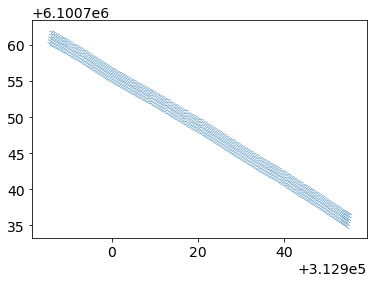

In [257]:
fig, ax = plt.subplots(1, 1)
ax.plot(xyz_data[easting, line_inds], xyz_data[northing, line_inds], '.', alpha=0.1, ms=0.2)

In [258]:
from scipy import stats

In [259]:
# segment the data into ~5m chunks (125 measurement numners)

line_data = xyz_data[datai, :][:, line_inds]

line_easting = xyz_data[easting, line_inds]
line_northing = xyz_data[northing, line_inds]
line_local_easting = line_easting - line_easting.mean()
line_local_northing = line_northing - line_northing.mean()

slope, intercept, _, _, _ = stats.linregress(line_local_easting, line_local_northing)
print(slope, intercept)

-0.3644498591436287 -3.5201730371691195e-10


In [262]:
theta = np.arctan(slope)+np.pi/2
line_x = np.cos(theta) * line_local_easting + np.sin(theta) * line_local_northing
line_y = -np.sin(theta) * line_local_easting + np.cos(theta) * line_local_northing

print(line_y[:10])

[-37.16919635 -37.16919635 -37.16919635 -37.15089263 -37.15089263
 -37.15089263 -37.13184324 -37.13184324 -37.13184324 -37.10631078]


Text(0.5, 1.0, 'rotated coordinate system')

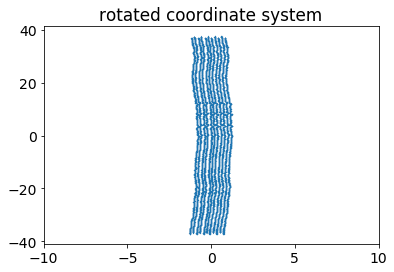

In [263]:
mn_line = mn[line_inds]
fig, ax = plt.subplots(1, 1)
ax.plot(line_x, line_y, '.', ms=0.2)
ax.set_xlim(np.r_[-10, 10])
ax.set_title("rotated coordinate system")

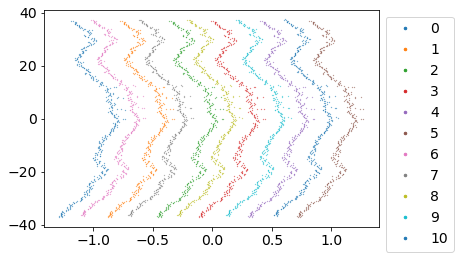

In [264]:
mn_line = mn[line_inds]
fig, ax = plt.subplots(1, 1)

for plot_mn in range(11):

    plot_inds = (mn_line==plot_mn)
    ax.plot(line_x[plot_inds], line_y[plot_inds], '.', ms=0.5, label=plot_mn)
ax.legend(bbox_to_anchor=[1, 0.1, 0, 0.9], markerscale=10)

In [269]:
# target data shape 165 X nlocs X nTimes 
# grab by measurement number 
# then re-stack

x_locs = []
y_locs = []
data_list = []

for mnind in range(mn.max() + 1):
    mninds = mn_line == mnind
    x_locs.append(line_x[mninds])
    y_locs.append(line_y[mninds])
    data_list.append(line_data[:, mninds].T)

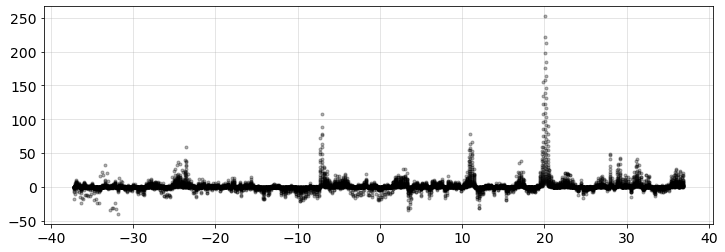

In [268]:
fig, ax = plt.subplots(1, 1, figsize=(12, 4))
ax.plot(y0, data0, '.', color="k", alpha=0.3)
ax.grid("both", alpha=0.4)

In [341]:
X_locs = np.vstack(x_locs)
Y_locs = np.vstack(y_locs)
S_data = np.stack(data_list, axis=0)
print(S_data.shape)

(165, 390, 27)


In [355]:
window_width = 25
w_step = 10
n_windows = (X_locs.shape[1]-window_width)//step + 1
print(n_windows)

37


In [357]:
n = S_data.shape
net_data = np.zeros((n_windows, n[0], window_width, n[2]))

for i in range(n_windows):
    net_data[i, :, :, :] = S_data[:, i*w_step:i*w_step+window_width, :]

In [379]:
net_data_torch = torch.from_numpy(np.float32(net_data))

In [383]:
with torch.no_grad():
    out_field = net(net_data_torch, K, batch_norm)
    n = W.shape
    S = torch.matmul(out_field.view(-1, n[0]), W)
    probs_field = functional.softmax(S, dim=1)

In [384]:
probs_field

tensor([[0.0000e+00, 1.3234e-19, 1.0000e+00],
        [0.0000e+00, 2.7026e-36, 1.0000e+00],
        [0.0000e+00, 1.0000e+00, 8.8880e-20],
        [0.0000e+00, 1.0000e+00, 5.4941e-14],
        [0.0000e+00, 7.3982e-01, 2.6018e-01],
        [0.0000e+00, 6.9618e-25, 1.0000e+00],
        [0.0000e+00, 8.2652e-11, 1.0000e+00],
        [0.0000e+00, 0.0000e+00, 1.0000e+00],
        [0.0000e+00, 4.7160e-11, 1.0000e+00],
        [0.0000e+00, 7.3820e-14, 1.0000e+00],
        [1.9618e-44, 1.0000e+00, 3.1373e-13],
        [9.1281e-17, 1.0000e+00, 2.3117e-13],
        [3.5407e-14, 9.9997e-01, 2.5102e-05],
        [3.1638e-06, 1.0000e+00, 1.3932e-07],
        [5.0026e-43, 9.3856e-01, 6.1444e-02],
        [0.0000e+00, 9.5944e-01, 4.0563e-02],
        [0.0000e+00, 1.0000e+00, 1.8590e-09],
        [0.0000e+00, 4.0574e-17, 1.0000e+00],
        [0.0000e+00, 0.0000e+00, 1.0000e+00],
        [0.0000e+00, 0.0000e+00, 1.0000e+00],
        [0.0000e+00, 0.0000e+00, 1.0000e+00],
        [0.0000e+00, 5.2848e-13, 1

In [385]:
_, labels_field = torch.max(probs_field, axis=1)

In [386]:
labels_field

tensor([2, 2, 1, 1, 1, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2,
        2, 1, 2, 2, 2, 2, 1, 1, 2, 2, 2, 2, 1])